# AutoEncoder

Building an Autoencoder roughly based on the U-Net.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import datetime

## Data Preprocessing

I will start by loading two of the images in. Then I will select from the originals each only one. Aftwards, I will select the 500 images in good and bad quality from the two image and create the classification label for it.

select = np.random.choice(np.arange(0, 4055), size = 1000)

In [2]:
X_1 = np.load('/scratch2/ttoebro/data/P10_X.npy')

In [3]:
X = X_1

In [4]:
X = X.reshape([4055, 256, 256, 1])

X = X[select, :, :]

In [5]:
del X_1

In [6]:
gc.collect()

19

 Normalize data

In [7]:
Y_1 = np.load('/scratch2/ttoebro/data/P10_Y.npy')

In [ ]:
Y = Y_1

In [ ]:
Y = Y.reshape([4055, 256, 256, 1])

In [ ]:
Y.shape

(4055, 256, 256, 1)

Y = Y[select, :, :]

clean up the mess

In [ ]:
gc.collect()

3

In [ ]:
Y.shape

(4055, 256, 256, 1)

# Create train and test and validation set

How much of the data should be used for training?

In [ ]:
train_frac = 0.9

In [ ]:
train_index = int(train_frac * Y.shape[0])

In [ ]:
X_train = X[0:train_index,:,:,:]
X_eval = X[train_index:X.shape[0],:,:,:]

In [ ]:
Y_train = Y[0:train_index,:,:]
Y_eval = Y[train_index:X.shape[0],:,:,:]

In [ ]:
def conv_2(tensor_in, name_layer, n_filter):
    x = tf.layers.conv2d(
        inputs = tensor_in,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_1")
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_2")
    
    return x

In [ ]:
def level_up(tensor_in, insert_layer, name_layer, n_filter):
    #print("Shape before level up: " + str(tensor_in.shape))
    x = tf.layers.conv2d_transpose(
            tensor_in,
            filters=n_filter,
            kernel_size=2,
            strides=2,
            padding = 'same',
            activation = tf.nn.relu,
            name=name_layer + "_upconv")
    #print("Shape after level up: " + str(x.shape))
    
    x = tf.concat([insert_layer, x], axis=-1, name=name_layer + "_insert")
    #print("Shape after putting in other vector: " + str(x.shape))
    
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_1")
    #print("Shape after first conv in level up: " + str(x.shape))
    
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_2")
    #print("Shape after second conv in level up: " + str(x.shape))
    
    return x

# Create and train CNN

In [53]:
def AutoEncoder_model(features, labels, mode):
       
    is_training_mode = (mode == tf.estimator.ModeKeys.TRAIN)
    
    # Input Tensor
    input_tensor = features['x']
    
    # Level 0
    level_0 = conv_2(input_tensor, "level_0", n_filter = 64)
    level_0_pool = tf.layers.max_pooling2d(level_0, (2, 2), strides=(2, 2), name="level_0_pooling")
    
    # Level 1
    level_1 = conv_2(level_0_pool, "level_1", n_filter = 128)
    level_1_pool = tf.layers.max_pooling2d(level_1, (2, 2), strides=(2, 2), name="level_1_pooling")
    
    # Level 2
    level_2 = conv_2(level_1_pool, "level_2", n_filter = 256)
    level_2_pool = tf.layers.max_pooling2d(level_2, (2, 2), strides=(2, 2), name="level_2_pooling")
    
    # Level 3
    level_3 = conv_2(level_2_pool, "level_3", n_filter = 512)
    level_3_pool = tf.layers.max_pooling2d(level_3, (2, 2), strides=(2, 2), name="level_3_pooling")
    
    # Level 4
    level_4 = conv_2(level_3_pool, "level_4", n_filter = 1024)
    
    # Level 3
    level_3_up = level_up(level_4,level_3,"level_3_up" , n_filter = 512)
    
    # Level 2
    level_2_up = level_up(level_3_up,level_2, "level_2_up" , n_filter = 256)
    
    # Level 1
    level_1_up = level_up(level_2_up,level_1, "level_1_up" , n_filter = 128)
    
    # Level 0
    level_0_up = level_up(level_1_up,level_0,"level_0_up"  , n_filter = 64)
    
        # final 
    final_layer = tf.layers.conv2d(
        inputs = level_0_up,
        filters = 1,
        kernel_size = [1, 1],
        padding = "same",
        activation = None,
        name = "final_layer")
        
    # Output all learnable variables for tensorboard
    for var in tf.trainable_variables():
        name = var.name
        name = name.replace(':', '_')
        tf.summary.histogram(name, var)
    merged_summary = tf.summary.merge_all()
    
    tf.summary.image("Input_Image", input_tensor, max_outputs = 1)
    tf.summary.image("Ouput_Image", final_layer, max_outputs = 1)
    tf.summary.image("True_Image", labels, max_outputs = 1)
    
    # Give output in prediction mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions=final_layer)
    

    # Calculate Loss (for both Train and EVAL modes)
    # See that the residual learning is implemented here.
    loss = tf.losses.mean_squared_error(labels = labels , predictions = final_layer)
    tf.summary.scalar("Value_Loss_Function", loss)
        
    # Configure the Training OP (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        original_optimizer = tf.train.AdamOptimizer(learning_rate =  0.005)
        optimizer = tf.contrib.estimator.clip_gradients_by_norm(original_optimizer, clip_norm=5.0)
        train_op = optimizer.minimize(loss = loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

Load train and test data

Create the estimator

In [54]:
runconf = tf.estimator.RunConfig(save_summary_steps=1, log_step_count_steps = 1)

In [55]:
AutoEncoder = tf.estimator.Estimator(config=runconf,
    model_fn=AutoEncoder_model, model_dir= "/tmp/AutoEncoder/testrun5")

INFO:tensorflow:Using config: {'_model_dir': '/tmp/AutoEncoder/testrun5', '_tf_random_seed': None, '_save_summary_steps': 1, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3577665748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Set up logging for predictions

Train the model

In [56]:
train = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=Y_train,
    batch_size=16,
    num_epochs=None,
    shuffle=True)

In [57]:
AutoEncoder.train(
    input_fn=train,
    steps=20)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/AutoEncoder/testrun5/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2 into /tmp/AutoEncoder/testrun5/model.ckpt.
INFO:tensorflow:loss = 1711.4202, step = 2
INFO:tensorflow:global_step/sec: 0.0110407
INFO:tensorflow:global_step/sec: 0.0111645
INFO:tensorflow:global_step/sec: 0.0109803
INFO:tensorflow:global_step/sec: 0.0111245
INFO:tensorflow:global_step/sec: 0.0108748
INFO:tensorflow:global_step/sec: 0.0108096
INFO:tensorflow:Saving checkpoints for 9 into /tmp/AutoEncoder/testrun5/model.ckpt.
INFO:tensorflow:global_step/sec: 0.0109381
INFO:tensorflow:global_step/sec: 0.011034
INFO:tensorflow:global_step/sec: 0.0112145
INFO:tensorflow:global_step/sec: 0.011085
INFO:tensorflow:global_step/sec: 0.0111832


## Evaluate the model

Make predictions

This is what we train for (our label)

This is the true image, can be calculated as the difference of X to the label we train on

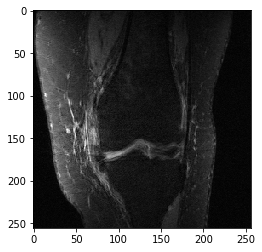

In [25]:
plt.imshow(Y_eval[1,:,:,0] , cmap='gray' )

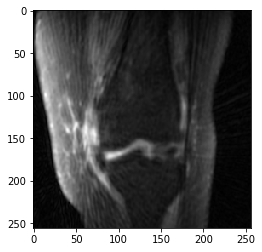

In [24]:
plt.imshow(X_eval[1,:,:,0] , cmap='gray' )

This is an original image. What does our network predict?

In [26]:
# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_eval[1:2,:,:,:]},
    y=X_eval[1:2,:,:,:],
    num_epochs=1,
    shuffle=False)
predict_results = AutoEncoder.predict(input_fn=predict_input_fn)
predict_results = list(predict_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/AutoEncoder/testrun3/model.ckpt-463
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


The first dictionary is the image shown above. Although I cannot see much in the picture the network is 99.8% sure that it is original!

In [30]:
predict_results[0]

array([[[0.02301582],
        [0.03623255],
        [0.04272982],
        ...,
        [0.03575763],
        [0.03507895],
        [0.02133241]],

       [[0.03384792],
        [0.05467601],
        [0.06603767],
        ...,
        [0.05327896],
        [0.05244428],
        [0.03232372]],

       [[0.03338828],
        [0.05474349],
        [0.06934074],
        ...,
        [0.05234609],
        [0.05151455],
        [0.03194467]],

       ...,

       [[0.03170604],
        [0.04777902],
        [0.04924558],
        ...,
        [0.048344  ],
        [0.04814705],
        [0.02995411]],

       [[0.03157017],
        [0.04732597],
        [0.04877244],
        ...,
        [0.04773751],
        [0.04721475],
        [0.02916918]],

       [[0.02021667],
        [0.02985028],
        [0.03085416],
        ...,
        [0.03010399],
        [0.02943398],
        [0.01880442]]], dtype=float32)

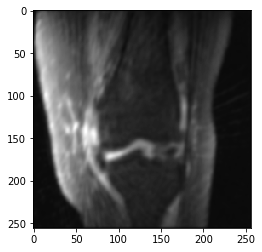

In [31]:
plt.imshow(predict_results[0][:,:,0], cmap='gray')